<a href="https://colab.research.google.com/github/deanwampler/RISECamp2019Tutorials/blob/master/exercise_3_pbt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Population-Based Training

### In this tutorial, we'll show you how to leverage Population-based Training.

<img src="pbt.png" alt="PBT" width="600"/>

Tune is a scalable framework for model training and hyperparameter search with a focus on deep learning and deep reinforcement learning.

* **Code**: https://github.com/ray-project/ray/tree/master/python/ray/tune 
* **Examples**: https://github.com/ray-project/ray/tree/master/python/ray/tune/examples
* **Documentation**: http://ray.readthedocs.io/en/latest/tune.html
* **Mailing List** https://groups.google.com/forum/#!forum/ray-dev

In [0]:
# If you are running on Google Colab, uncomment below to install the necessary dependencies 
# before beginning the exercise.

print("Setting up colab environment")
!pip uninstall -y -q pyarrow
!pip install -q https://s3-us-west-2.amazonaws.com/ray-wheels/latest/ray-0.8.0.dev5-cp36-cp36m-manylinux1_x86_64.whl
!pip install -q ray[debug]

# A hack to force the runtime to restart, needed to include the above dependencies.
print("Done installing! Restarting via forced crash (this is not an issue).")
import os
os._exit(0)

Setting up colab environment
     |████████████████████████████████| 75.9MB 1.2MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
     |████████████████████████████████| 1.3MB 14.2MB/s 
     |████████████████████████████████| 2.8MB 5.1MB/s 


In [2]:
import tensorflow as tf
try:
    tf.get_logger().setLevel('INFO')
except Exception as exc:
    print(exc)
import warnings
warnings.simplefilter("ignore")

import os
import numpy as np
import torch
import torch.optim as optim
from torchvision import datasets
from ray.tune.examples.mnist_pytorch import train, test, ConvNet, get_data_loaders

import ray
from ray import tune
from ray.tune import track
from ray.tune.schedulers import PopulationBasedTraining
from ray.tune.util import validate_save_restore

%matplotlib inline
import matplotlib.style as style
import matplotlib.pyplot as plt
style.use("ggplot")

datasets.MNIST("~/data", train=True, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

100%|█████████▉| 9912320/9912422 [02:27<00:00, 59548.43it/s]

Extracting /root/data/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/MNIST/raw



0it [00:00, ?it/s]
  0%|          | 0/28881 [00:00<?, ?it/s]


 85%|████████▌ | 24576/28881 [00:00<00:00, 39666.63it/s]
32768it [00:00, 39721.74it/s]                           
0it [00:00, ?it/s]
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /root/data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/MNIST/raw



 42%|████▏     | 688128/1648877 [00:10<00:17, 54496.47it/s]
9920512it [02:40, 59548.43it/s]                             
 99%|█████████▉| 1638400/1648877 [00:31<00:00, 78981.26it/s]

0it [00:00, ?it/s]

Extracting /root/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/MNIST/raw




  0%|          | 0/4542 [00:01<?, ?it/s]

8192it [00:01, 45480.67it/s]            



Extracting /root/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/MNIST/raw
Processing...
Done!


Dataset MNIST
    Number of datapoints: 60000
    Root location: /root/data
    Split: Train

# Setup Trainable


To utilize the PopulationBasedTraining Scheduler, we will have to use Tune's more extensive Class-based API. 

This API will allow Tune to take intermediate actions such as checkpointing and changing the hyperparameters in the middle of training.

``train()`` wraps ``_train()``.

A call to ``train()`` on a trainable will execute one logical iteration of training. As a rule of thumb, the execution time of one train call should be large enough to avoid overheads (i.e. more than a few seconds), but short enough to report progress periodically (i.e. at most a few minutes).

### Instructions:

Add training code under ``_train`` as follows:

```python
    def _train(self):
        train(self.model, self.optimizer, self.train_loader, device=self.device)
        acc = test(self.model, self.test_loader, self.device)
        return {"mean_accuracy": acc}
```

In [3]:
class PytorchTrainble(tune.Trainable):
    def _setup(self, config):
        self.device = torch.device("cpu")
        self.train_loader, self.test_loader = get_data_loaders()
        self.model = ConvNet().to(self.device)
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=config.get("lr", 0.01),
            momentum=config.get("momentum", 0.9))

    def _train(self):
        # TODO: Add training code here.
        train(self.model, self.optimizer, self.train_loader, device=self.device)
        acc = test(self.model, self.test_loader, self.device)
        return {"mean_accuracy": acc}

    def _save(self, checkpoint_dir):
        checkpoint_path = os.path.join(checkpoint_dir, "model.pth")
        torch.save(self.model.state_dict(), checkpoint_path)
        return checkpoint_path

    def _restore(self, checkpoint_path):
        self.model.load_state_dict(torch.load(checkpoint_path))
        
    def reset_config(self, new_config):
        del self.optimizer
        self.optimizer = optim.SGD(
            self.model.parameters(),
            lr=new_config.get("lr", 0.01),
            momentum=new_config.get("momentum", 0.9))
        return True


ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)

validate_save_restore(PytorchTrainble)
validate_save_restore(PytorchTrainble, use_object_store=True)
print("Success!")

2019-10-17 19:41:34,398	INFO resource_spec.py:205 -- Starting Ray with 6.05 GiB memory available for workers and up to 3.04 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Success!


# Use population-based training with 2 samples

PBT uses information from the rest of the population to refine the hyperparameters and direct computational resources to models which show promise. 

In PBT, a worker might copy the model parameters from a better performing worker. It can also explore new hyperparameters by changing the current values randomly (``hyperparam_mutations``).



As the training of the population of neural networks progresses, this process of exploiting and exploring is performed periodically, ensuring that all the workers in the population have a good base level of performance and also that new hyperparameters are consistently explored.  This means that PBT can quickly exploit good hyperparameters, can dedicate more training time to promising models and, crucially, can adapt the hyperparameter values throughout training, leading to automatic learning of the best configurations.

In [0]:
scheduler = PopulationBasedTraining(
    time_attr="training_iteration",
    metric="mean_accuracy",
    mode="max",
    perturbation_interval=5,
    hyperparam_mutations={
        # distribution for resampling
        "lr": lambda: np.random.uniform(0.0001, 1),
        # allow perturbations within this set of categorical values
        "momentum": [0.8, 0.9, 0.99],
    }
)

In [5]:
ray.shutdown()  # Restart Ray defensively in case the ray connection is lost. 
ray.init(log_to_driver=False)


analysis = tune.run(
    PytorchTrainble,
    name="pbt_test",
    scheduler=scheduler,
    reuse_actors=True,
    verbose=1,
    stop={
        "training_iteration": 100,
    },
    num_samples=4,
    
    # PBT starts by training many neural networks in parallel with random hyperparameters. 
    config={
        "lr": tune.uniform(0.001, 1),
        "momentum": tune.uniform(0.001, 1),
    })


Trial name,ID,status,loc,momentum,lr,iter,total time (s),acc
PytorchTrainble_7f816484,7f816484,TERMINATED,pid=539,0.945551,0.145209,100,49.7458,0.940625
PytorchTrainble_7f82b1f4,7f82b1f4,TERMINATED,pid=515,0.584342,0.111904,100,48.0581,0.946875
PytorchTrainble_7f83d1ce,7f83d1ce,TERMINATED,pid=539,0.945551,0.145209,100,47.7538,0.9375
PytorchTrainble_7f853622,7f853622,TERMINATED,pid=515,0.584342,0.111904,100,47.4192,0.859375


2019-10-17 19:46:02,089	INFO tune.py:285 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


In [6]:
# You can use this to visualize all mutations of Population-based Training.
! cat ~/ray_results/pbt_test/pbt_global.txt

["2_lr=0.1119,momentum=0.58434", "0_lr=0.29441,momentum=0.63457", 9, 10, {"lr": 0.29440642206878687, "momentum": 0.6345687651410256}, {"lr": 0.3532877064825442, "momentum": 0.99}]
["2_lr=0.1119,momentum=0.58434", "1_lr=0.29348,momentum=0.4912", 14, 15, {"lr": 0.2934779781878045, "momentum": 0.4912048219546437}, {"lr": 0.3521735738253654, "momentum": 0.9}]
["2_lr=0.1119,momentum=0.58434", "1_lr=0.29348,momentum=0.4912", 19, 20, {"lr": 0.2934779781878045, "momentum": 0.4912048219546437}, {"lr": 0.23478238255024364, "momentum": 0.9}]
["2_lr=0.1119,momentum=0.58434", "0_lr=0.29441,momentum=0.63457", 24, 25, {"lr": 0.29440642206878687, "momentum": 0.6345687651410256}, {"lr": 0.6819258538247831, "momentum": 0.99}]
["2_lr=0.1119,momentum=0.58434", "1_lr=0.29348,momentum=0.4912", 29, 30, {"lr": 0.2934779781878045, "momentum": 0.4912048219546437}, {"lr": 0.6297722494889437, "momentum": 0.9}]
["2_lr=0.1119,momentum=0.58434", "1_lr=0.29348,momentum=0.4912", 34, 35, {"lr": 0.2934779781878045, "mom

# Visualizing the results of Population-based Training

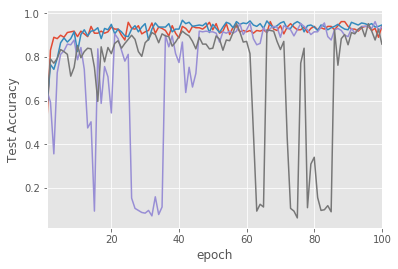

In [7]:
# Plot by wall-clock time

dfs = analysis.fetch_trial_dataframes()
# This plots everything on the same plot
ax = None
for d in dfs.values():
    ax = d.plot("training_iteration", "mean_accuracy", ax=ax, legend=False)

plt.xlabel("epoch"); plt.ylabel("Test Accuracy"); 